<a href="https://colab.research.google.com/github/hugosousa111/mask-rcnn-covid19/blob/main/COVID_Mask_Pre_NII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configurações Drive

In [1]:
# Acessa o Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Caminhos das imagens, Tomografias e Mascaras das infecções
DATASET_PATH = "/content/drive/MyDrive/kaggle/"
PATH_ct = DATASET_PATH+'CTS/'
PATH_infMask = DATASET_PATH+'INFEC/'

# Bibliotecas

In [3]:
!git clone https://github.com/pytorch/vision.git
%cd vision
!git checkout v0.3.0

!cp references/detection/utils.py ../
!cp references/detection/transforms.py ../
!cp references/detection/coco_eval.py ../
!cp references/detection/engine.py ../
!cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 22725, done.
remote: Counting objects: 100% (187/187), done.
remote: Compressing objects: 100% (177/177), done.
remote: Total 22725 (delta 94), reused 64 (delta 6), pack-reused 22538
Receiving objects: 100% (22725/22725), 29.45 MiB | 15.39 MiB/s, done.
Resolving deltas: 100% (16792/16792), done.
/content/vision
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


In [4]:
%cd /content/

/content


In [5]:
import pandas as pd
import numpy as np
import nibabel as nib
import cv2
import random
import os
import PIL
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.utils.data
import torchvision.transforms as T_
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow
from engine import train_one_epoch, evaluate
import utils
import transforms as T

In [6]:
# O arquivo csv com os caminhos
raw_data = pd.read_csv(DATASET_PATH+'metadata.csv')
raw_data = raw_data.replace('../input/covid19-ct-scans/',DATASET_PATH,regex=True)
print(raw_data.shape)
raw_data.head(5)

(20, 4)


,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,/content/drive/MyDrive/kaggle/ct_scans/coronac...,/content/drive/MyDrive/kaggle/lung_mask/corona...,/content/drive/MyDrive/kaggle/infection_mask/c...,/content/drive/MyDrive/kaggle/lung_and_infecti...
1,/content/drive/MyDrive/kaggle/ct_scans/coronac...,/content/drive/MyDrive/kaggle/lung_mask/corona...,/content/drive/MyDrive/kaggle/infection_mask/c...,/content/drive/MyDrive/kaggle/lung_and_infecti...
2,/content/drive/MyDrive/kaggle/ct_scans/coronac...,/content/drive/MyDrive/kaggle/lung_mask/corona...,/content/drive/MyDrive/kaggle/infection_mask/c...,/content/drive/MyDrive/kaggle/lung_and_infecti...
3,/content/drive/MyDrive/kaggle/ct_scans/coronac...,/content/drive/MyDrive/kaggle/lung_mask/corona...,/content/drive/MyDrive/kaggle/infection_mask/c...,/content/drive/MyDrive/kaggle/lung_and_infecti...
4,/content/drive/MyDrive/kaggle/ct_scans/coronac...,/content/drive/MyDrive/kaggle/lung_mask/corona...,/content/drive/MyDrive/kaggle/infection_mask/c...,/content/drive/MyDrive/kaggle/lung_and_infecti...


# Funções de pre-processamento

In [7]:
def clahe_enhancer(img):
    img = np.uint8(img*255)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    clahe_img = clahe.apply(img)
    return clahe_img

def cropper(test_img):

    test_img = test_img*255
    test_img = np.uint8(test_img)    
    contours,hierarchy = cv2.findContours(test_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(c) for c in contours]  
    
    x = np.argsort(areas)   
    max_index = x[x.size - 1]
    cnt1=contours[max_index]
    second_max_index = x[x.size - 2]
    cnt2 = contours[second_max_index]    
    x,y,w,h = cv2.boundingRect(cnt1)
    p,q,r,s = cv2.boundingRect(cnt2)    
    cropped1 = test_img[y:y+h, x:x+w]
    cropped1 = cv2.resize(cropped1, dsize=(125,250), interpolation=cv2.INTER_AREA)
    cropped2 = test_img[q:q+s, p:p+r]
    cropped2 = cv2.resize(cropped2, dsize=(125,250), interpolation=cv2.INTER_AREA)

    if x < p:
        fused = np.concatenate((cropped1, cropped2), axis=1)
    else:
        fused = np.concatenate((cropped2, cropped1), axis=1)

    points_lung1 = []
    points_lung2 = []   
    points_lung1.append(x); points_lung1.append(y); points_lung1.append(w); points_lung1.append(h)
    points_lung2.append(p); points_lung2.append(q); points_lung2.append(r); points_lung2.append(s)

    return (fused, points_lung1, points_lung2)

# Carrega e prepara as imagens

In [8]:
all_points1 = []
all_points2 = []

def read_nii(filepath, data, string):
    global all_points1
    global all_points2
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    slices = array.shape[2]
    array = array[:,:,round(slices*0.2):round(slices*0.8)]
    array = np.reshape(np.rollaxis(array, 2),(array.shape[2],array.shape[0],array.shape[1],1))

    if string == "lungs":
        all_points1 = []
        all_points2 = []

    for img_no in range(0, array.shape[0]):
        if string == 'lungs' and np.unique(array[img_no]).size == 1:
            continue
        img = cv2.resize(array[img_no], dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)
        # nomaliza img
        xmax, xmin = img.max(), img.min()
        img = (img - xmin)/(xmax - xmin)

        if string == 'lungs':
            # img = np.uint8(img*255) 
            img[img>0]=1
            img, points1, points2 = cropper(img)
            all_points1.append((points1[0], points1[1], points1[2], points1[3]))
            all_points2.append((points2[0], points2[1], points2[2], points2[3]))
            continue 

        if string == "cts" and img_no < len(all_points1):
            img = clahe_enhancer(img)   
            a,b,c,d = all_points1[img_no]
            e,f,g,h = all_points2[img_no]
            img1 = img[b:b+d, a:a+c]
            img1 = cv2.resize(img1, dsize=(125,250), interpolation=cv2.INTER_AREA)
            img2 = img[f:f+h, e:e+g]
            img2 = cv2.resize(img2, dsize=(125,250), interpolation=cv2.INTER_AREA)
            if a<e:
                img = np.concatenate((img1, img2), axis=1)    
            else:
                img = np.concatenate((img2, img1), axis=1)

        if string == "infections" and img_no < len(all_points1):
            a,b,c,d = all_points1[img_no]
            e,f,g,h = all_points2[img_no]
            img = np.uint8(img*255)
            img1 = img[b:b+d, a:a+c]
            img1 = cv2.resize(img1, dsize=(125,250), interpolation=cv2.INTER_AREA)
            img2 = img[f:f+h, e:e+g]
            img2 = cv2.resize(img2, dsize=(125,250), interpolation=cv2.INTER_AREA)
            if a<e:
                img = np.concatenate((img1, img2), axis=1)    
            else:
                img = np.concatenate((img2, img1), axis=1)
        img = cv2.resize(img, dsize=(img_size, img_size), interpolation=cv2.INTER_LINEAR)
        data.append(img)

In [9]:
# Carrega as imagens e pré-processa
cts = []
lungs = []
infections = []
img_size = 224
for i in range(0, 20):
    read_nii(raw_data.loc[i,'lung_mask'], lungs, 'lungs')
    read_nii(raw_data.loc[i,'ct_scan'], cts, 'cts')
    read_nii(raw_data.loc[i,'infection_mask'], infections, 'infections')

print(len(cts), len(infections))

2112 2112


In [10]:
# Elimina as imagens sem infecções
blank_infections = []
for i in range(0, len(infections)):
  if np.unique(infections[i]).size == 1:
    blank_infections.append(i)
print("Number of complete black masks :" , len(blank_infections))

for index in sorted(blank_infections, reverse = True):  
    del infections[index]  
    del cts[index]

Number of complete black masks : 497


In [11]:
# Elimina imagens problematicas
nan_list = []
for img_id in range(len(infections)):
    if np.isnan(infections[img_id].sum()):
        nan_list.append(img_id)
print(nan_list)

[1476]


In [12]:
del infections[1476]
del cts[1476]

In [13]:
# Elimina imagens problematicas
blank_cts = []
for i in range(0, len(cts)):
  if sum(sum(cts[i]>1)) == 0:
    blank_cts.append(i)
print("Number of complete black cts :" , len(blank_cts))
print(blank_cts)

for index in sorted(blank_cts, reverse = True):  
    del infections[index]  
    del cts[index]

Number of complete black cts : 5
[1243, 1244, 1245, 1246, 1476]


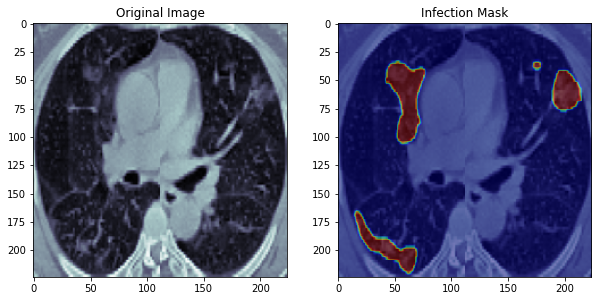

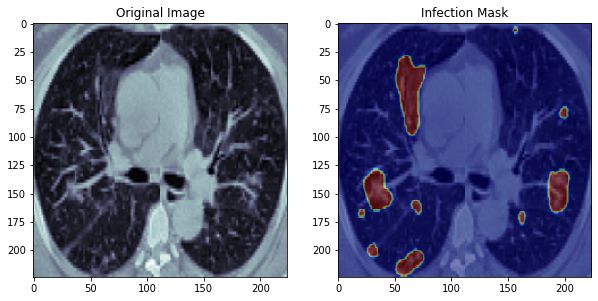

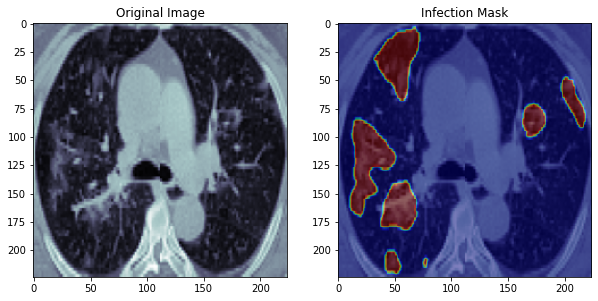

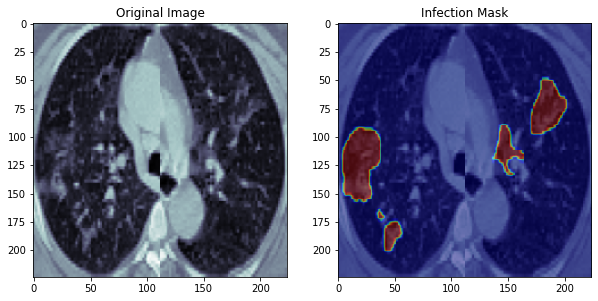

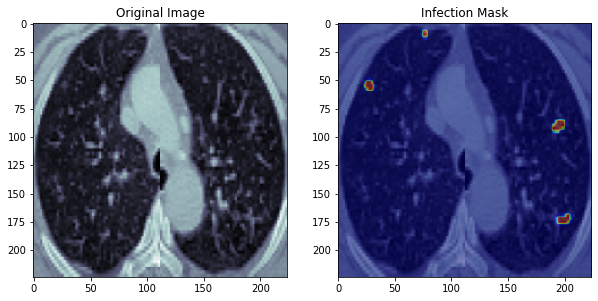

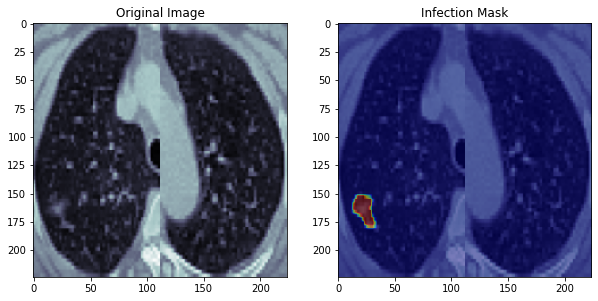

In [14]:
def plot_sample(array_list, color_map = 'jet'):
    fig = plt.figure(figsize=(10,30))

    plt.subplot(1,2,1)
    plt.imshow(array_list[0].reshape(224, 224), cmap='bone')
    plt.title('Original Image')

    plt.subplot(1,2,2)
    plt.imshow(array_list[0].reshape(224, 224), cmap='bone')
    plt.imshow(array_list[1].reshape(224, 224), alpha=0.5, cmap=color_map)
    plt.title('Infection Mask')
    plt.show()

for index in [100,110,120,130,140,150]:
    plot_sample([cts[index], infections[index]])

## Corrige mask

In [15]:
for j in range(len(infections)): 
    mask = infections[j]
    [l, c] = np.shape(mask)
    for c_ in range(c):
        for l_ in range(l):
            if mask[l_, c_] != 0:
                mask[l_, c_] = 255
    infections[j] = mask

# Divide em Treino e Teste

In [16]:
TRAINING_SPLIT = 0.8

cts_train = []
cts_test = []
infections_train = []
infections_test = []

np.random.seed(42)

randomlist = random.sample(range(0, len(cts)), len(cts))

temp_cts = np.copy(cts)
temp_infections = np.copy(infections)

for i in range(len(cts)):
    cts[i] = temp_cts[randomlist[i]]
    infections[i] = temp_infections[randomlist[i]]

i = int(len(cts) * TRAINING_SPLIT)
cts_train = cts[:i]
cts_test = cts[i:]
infections_train = infections[:i]
infections_test = infections[i:]

# Classe InfectionDataset (que carrega os dados para a rede)

In [17]:
class InfectionDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = cts_train
        self.masks = infections_train

    def __getitem__(self, idx):
        img = Image.fromarray(np.uint8(self.imgs[idx])).convert('RGB')
        
        mask = Image.fromarray(np.uint8(self.masks[idx])).convert('RGB')
        mask = np.asarray(mask)[:,:,::-1].copy()
        
        mask = mask[:, :, 1]
        ret,mask =cv2.threshold(mask,127,1,cv2.THRESH_BINARY)

        mask = np.array(mask)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

# Define build_model

In [18]:
def build_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Stop here if you are fine-tunning Faster-RCNN

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

# Treinamento

In [19]:
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)
    
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [20]:
def treinamento(LR, M, WD):
    # use our dataset and defined transformations
    dataset = InfectionDataset('/content/drive/MyDrive/kaggle', get_transform(train=True))
    dataset_test = InfectionDataset('/content/drive/MyDrive/kaggle', get_transform(train=False))

    # split the dataset in train and test set
    torch.manual_seed(1)
    indices = torch.randperm(len(dataset)).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[:-50])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=4,
        collate_fn=utils.collate_fn)    

    #device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # our dataset has two classes only - background and person
    num_classes = 2

    # get the model using our helper function
    model = build_model(num_classes)
    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=LR, momentum=M, weight_decay=WD)

    # and a learning rate scheduler which decreases the learning rate by
    # 10x every 3 epochs
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    # number of epochs
    num_epochs = 50

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)

    nome_arquivo = '/content/drive/MyDrive/kaggle/mask-rcnn-pedestrian-lr_'+str(LR)+'-m_'+str(M)+'-wd_'+str(WD)+'.pt'
    torch.save(model, nome_arquivo)

In [21]:
vet_LR = [0.005, 0.05, 0.5, 0.1]
vet_M = [0.9, 0.5, 0.3]
vet_WD = [0.0005, 0.005, 0.05]

#LR = 0.005
#M = 0.9
#WD = 0.0005

In [22]:
for LR in vet_LR:
    for M in vet_M: 
        for WD in vet_WD:
            print('LR - ', LR,' M - ', M,' WD - ', WD)
            '''
            if LR == 0.005 and (M == 0.9 or M == 0.5 or M == 0.3) and (WD == 0.0005 or WD == 0.005 or WD == 0.05):
                continue
            if LR == 0.05 and (M == 0.9 or M == 0.5 or M == 0.3) and (WD == 0.0005 or WD == 0.005 or WD == 0.05):
                continue
            if LR == 0.5 and (M == 0.9 or M == 0.5 or M == 0.3) and (WD == 0.0005 or WD == 0.005 or WD == 0.05):
                continue
            if LR == 0.1 and (M == 0.9 or M == 0.5 or M == 0.3) and (WD == 0.0005 or WD == 0.005 or WD == 0.05):
                continue
            '''
            treinamento(LR = LR, M = M, WD = WD)

LR -  0.005  M -  0.9  WD -  0.0005
LR -  0.005  M -  0.9  WD -  0.005
LR -  0.005  M -  0.9  WD -  0.05
LR -  0.005  M -  0.5  WD -  0.0005
LR -  0.005  M -  0.5  WD -  0.005
LR -  0.005  M -  0.5  WD -  0.05
LR -  0.005  M -  0.3  WD -  0.0005
LR -  0.005  M -  0.3  WD -  0.005
LR -  0.005  M -  0.3  WD -  0.05
LR -  0.05  M -  0.9  WD -  0.0005
LR -  0.05  M -  0.9  WD -  0.005
LR -  0.05  M -  0.9  WD -  0.05
LR -  0.05  M -  0.5  WD -  0.0005
LR -  0.05  M -  0.5  WD -  0.005
LR -  0.05  M -  0.5  WD -  0.05
LR -  0.05  M -  0.3  WD -  0.0005
LR -  0.05  M -  0.3  WD -  0.005
LR -  0.05  M -  0.3  WD -  0.05
LR -  0.5  M -  0.9  WD -  0.0005
LR -  0.5  M -  0.9  WD -  0.005
LR -  0.5  M -  0.9  WD -  0.05
LR -  0.5  M -  0.5  WD -  0.0005
LR -  0.5  M -  0.5  WD -  0.005
LR -  0.5  M -  0.5  WD -  0.05
LR -  0.5  M -  0.3  WD -  0.0005
LR -  0.5  M -  0.3  WD -  0.005
LR -  0.5  M -  0.3  WD -  0.05
LR -  0.1  M -  0.9  WD -  0.0005
LR -  0.1  M -  0.9  WD -  0.005
LR -  0.1  M - 

# Testes

In [23]:
def get_coloured_mask(mask):
    colours = [[255, 255, 255]]
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    r[mask == 1], g[mask == 1], b[mask == 1] = colours[0]
    coloured_mask = r
    return coloured_mask

def get_prediction(img_path, model, CLASS_NAMES, confidence):
    img = Image.fromarray(np.uint8(img_path)).convert('RGB')
    transform = T_.Compose([T_.ToTensor()])
    img = transform(img)
    img = img.to(device)
    pred = model([img])
    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    try:
        pred_t = [pred_score.index(x) for x in pred_score if x>confidence][-1]
    except IndexError:   
        pred_t = 0
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    pred_class = [CLASS_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return masks, pred_boxes, pred_class

def segment_instance(img_path, model, CLASS_NAMES, confidence=0.5, rect_th=2, text_size=2, text_th=2):
    masks, boxes, pred_cls = get_prediction(img_path, model, CLASS_NAMES, confidence)
    img = Image.fromarray(np.uint8(img_path)).convert('RGB')
    img = np.asarray(img)[:,:,::-1].copy()
    [l, c, p] = np.shape(img)
    for p_ in range(p):
        for c_ in range(c):
            for l_ in range(l):
                img[l_, c_, p_] = 0
    try: 
        for i in range(len(masks)):
            [l, c] = np.shape(masks[i])
            for c_ in range(c):
                for l_ in range(l):
                    if masks[i][l_, c_] != 0:
                        img[l_, c_, 0] = masks[i][l_, c_]
            
    except ValueError:   
        pred_t = 0
        for i in range(len(masks)):
            [l] = np.shape(masks[i])
            for l_ in range(l):
                if masks[i][l_] != 0:
                    img[l_, 0, 0] = masks[i][l_]
    for p_ in range(p):
        for c_ in range(c):
            for l_ in range(l):
                if img[l_, c_, p_] != 0:
                    img[l_, c_, p_] = 255        
    img = img[:,:, 0]
    return img

In [24]:
def calc_T_F_P_N(A, B):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    li, co = A.shape
    for l in range(0,li):
        for c in range(0,co):
            if A[l,c] == B[l,c]: 
                if A[l,c] == 255:
                    TP = TP + 1
                else: 
                    TN = TN + 1
            else: 
                if A[l,c] == 255:
                    FN = FN+1
                else:
                    FP = FP+1
    return TP, TN, FP, FN

def calc_jaccard(TP, TN, FP, FN):
    #IOU
    if (TP + FP + FN) == 0:
        return 0
    else:
        return  TP / (TP + FP + FN)
     
def calc_dice(TP, TN, FP, FN):
    #F1_SCORE
    if ((2*TP) + FP + FN) == 0:
        return 0
    else:
        return (2*TP) / ((2*TP) + FP + FN)

def calc_precisao(TP, TN, FP, FN):
    # VPP
    if (TP + FP) == 0:
        return 0
    else:
        return TP / (TP + FP)

def calc_recall(TP, TN, FP, FN):
    # Sensibilidade / Revocação
    if (TP + FN) == 0:
        return 0
    else:
        return TP / (TP + FN)

def calc_especificidade(TP, TN, FP, FN):
    # Taxa de verdadeiros negativos
    if (TN + FP) == 0:
        return 0
    else:
        return TN / (TN + FP)

def calc_acuracia(TP, TN, FP, FN):
    return (TP + TN)/(TP + TN + FP + FN)

def calc_mcc(TP, TN, FP, FN):
    #MCC (Mathew Correlation Coefficient)
    return ((TP * TN) - (FP * FN))/np.sqrt((TP+FN)*(TP+FP)*(TN+FN))
    
def calc_metrics(A, B): 
    TP, TN, FP, FN = calc_T_F_P_N(A, B)
    #print(TP, TN, FP, FN)
    j = calc_jaccard(TP, TN, FP, FN)
    d = calc_dice(TP, TN, FP, FN)
    p = calc_precisao(TP, TN, FP, FN)
    r = calc_recall(TP, TN, FP, FN)
    e = calc_especificidade(TP, TN, FP, FN)
    a = calc_acuracia(TP, TN, FP, FN)
    m = calc_mcc(TP, TN, FP, FN)
    
    return TP, TN, FP, FN, j, d, p, r, e, a, m

In [25]:
def teste(LR, M, WD, cts_t, infections_t):
    nome_arquivo = '/content/drive/MyDrive/kaggle/MODELOS/mask-rcnn-pedestrian-lr_'+str(LR)+'-m_'+str(M)+'-wd_'+str(WD)+'.pt'
    model = torch.load(nome_arquivo)
    
    model.eval()
    CLASS_NAMES = ['__background__', 'infection']
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)

    #TP, TN, FP, FN, j, d, p, r, e, a, m
    metrics = np.zeros((len(cts_t), 11))

    conf = 0.7
    i = 0
    for img in range(len(cts_t)):
        if (i%50) == 0:
            print("IMG - ",i) 

        img = segment_instance(cts_t[i], model, CLASS_NAMES, confidence=conf)
        mask = Image.fromarray(np.uint8(infections_t[i])).convert('RGB')
        mask = np.asarray(mask)[:,:,::-1].copy()
        mask = mask[:,:, 0]
        #cv2_imshow(img)
        #cv2_imshow(mask)  
        #TP, TN, FP, FN, j[i], d[i], p[i], r[i], a[i] = calc_metrics(img, mask)
        metrics[i] = calc_metrics(mask, img)
        #print(metrics[i])
        i = i+1

    return metrics

## Resultados

In [26]:
for LR in vet_LR:
    for M in vet_M: 
        for WD in vet_WD:
            print('LR - ', LR,' M - ', M,' WD - ', WD)
            '''
            if LR == 0.005 and (M == 0.9 or M == 0.5 or M == 0.3) and (WD == 0.0005 or WD == 0.005 or WD == 0.05):
                continue
            if LR == 0.05 and (M == 0.9 or M == 0.5 or M == 0.3) and (WD == 0.0005 or WD == 0.005 or WD == 0.05):
                continue
            if LR == 0.5 and (M == 0.9 or M == 0.5 or M == 0.3) and (WD == 0.0005 or WD == 0.005 or WD == 0.05):
                continue
            if LR == 0.1 and (M == 0.9 or M == 0.5 or M == 0.3) and (WD == 0.0005 or WD == 0.005 or WD == 0.05):
                continue
            '''
            metrics = teste(LR, M, WD, cts_test, infections_test)
            arq = open(DATASET_PATH+'Result/metrics-test-lr_'+str(LR)+'-m_'+str(M)+'-wd_'+str(WD)+'.txt', 'w')
            np.savetxt(arq, metrics)
            arq.close()

            metrics = teste(LR, M, WD, cts_train, infections_train)
            arq = open(DATASET_PATH+'Result/metrics-train-lr_'+str(LR)+'-m_'+str(M)+'-wd_'+str(WD)+'.txt', 'w')
            np.savetxt(arq, metrics)
            arq.close()

LR -  0.005  M -  0.9  WD -  0.0005
LR -  0.005  M -  0.9  WD -  0.005
LR -  0.005  M -  0.9  WD -  0.05
LR -  0.005  M -  0.5  WD -  0.0005
LR -  0.005  M -  0.5  WD -  0.005
LR -  0.005  M -  0.5  WD -  0.05
LR -  0.005  M -  0.3  WD -  0.0005
LR -  0.005  M -  0.3  WD -  0.005
LR -  0.005  M -  0.3  WD -  0.05
LR -  0.05  M -  0.9  WD -  0.0005
LR -  0.05  M -  0.9  WD -  0.005
LR -  0.05  M -  0.9  WD -  0.05
LR -  0.05  M -  0.5  WD -  0.0005
LR -  0.05  M -  0.5  WD -  0.005
LR -  0.05  M -  0.5  WD -  0.05
LR -  0.05  M -  0.3  WD -  0.0005
LR -  0.05  M -  0.3  WD -  0.005
LR -  0.05  M -  0.3  WD -  0.05
LR -  0.5  M -  0.9  WD -  0.0005
LR -  0.5  M -  0.9  WD -  0.005
LR -  0.5  M -  0.9  WD -  0.05
LR -  0.5  M -  0.5  WD -  0.0005
LR -  0.5  M -  0.5  WD -  0.005
LR -  0.5  M -  0.5  WD -  0.05
LR -  0.5  M -  0.3  WD -  0.0005
LR -  0.5  M -  0.3  WD -  0.005
LR -  0.5  M -  0.3  WD -  0.05
LR -  0.1  M -  0.9  WD -  0.0005
LR -  0.1  M -  0.9  WD -  0.005
LR -  0.1  M - 

In [27]:
pos = len(vet_LR) * len(vet_M) * len(vet_WD)
medias_das_medias_treino = np.zeros([pos, 4 ])
medias_das_medias_teste = np.zeros([pos, 4 ])

In [28]:
cont = 0
for LR in vet_LR:
    for M in vet_M: 
        for WD in vet_WD:

            if LR == 0.05 and (M == 0.9) and (WD == 0.0005):
                continue
            if LR == 0.5 and (M == 0.9) and (WD == 0.0005 or WD == 0.005 or WD == 0.05):
                continue
            if LR == 0.5 and (M == 0.5 or M == 0.3) and (WD == 0.0005 or WD == 0.005):
                continue
            if LR == 0.1 and (M == 0.9 or M == 0.5) and (WD == 0.0005 or WD == 0.005):
                continue
            if LR == 0.1 and (M == 0.3) and (WD == 0.0005 or WD == 0.05):
                continue
            print("*********************************")
            print('LR - ', LR,' M - ', M,' WD - ', WD)
            metrics = np.loadtxt(DATASET_PATH+'Result/metrics-test-lr_'+str(LR)+'-m_'+str(M)+'-wd_'+str(WD)+'.txt')

            medias = np.zeros(6)
            desvios = np.zeros(6)

            medias[0] = np.mean(metrics[:,4])
            desvios[0] = np.std(metrics[:,4])
            medias[1] = np.mean(metrics[:,5])
            desvios[1] = np.std(metrics[:,5])
            medias[2] = np.mean(metrics[:,6])
            desvios[2] = np.std(metrics[:,6])
            medias[3] = np.mean(metrics[:,7])
            desvios[3] = np.std(metrics[:,7])
            medias[4] = np.mean(metrics[:,8])
            desvios[4] = np.std(metrics[:,8])
            medias[5] = np.mean(metrics[:,9])
            desvios[5] = np.std(metrics[:,9])
            #medias[6] = np.mean(metrics[:,10])
            #desvios[6] = np.std(metrics[:,10])

            print('Teste')
            print('J - m: '+str(medias[0])+' d: '+str(desvios[0]))
            print('D - m: '+str(medias[1])+' d: '+str(desvios[1]))
            print('P - m: '+str(medias[2])+' d: '+str(desvios[2]))
            print('R - m: '+str(medias[3])+' d: '+str(desvios[3]))
            print('E - m: '+str(medias[4])+' d: '+str(desvios[4]))
            print('A - m: '+str(medias[5])+' d: '+str(desvios[5]))
            #print('M - m: '+str(medias[6])+' d: '+str(desvios[6]))

            medias_das_medias_teste[cont, 0] = np.mean(medias)
            medias_das_medias_teste[cont, 1] = LR
            medias_das_medias_teste[cont, 2] = M
            medias_das_medias_teste[cont, 3] = WD

            metrics = np.loadtxt(DATASET_PATH+'Result/metrics-train-lr_'+str(LR)+'-m_'+str(M)+'-wd_'+str(WD)+'.txt')

            medias = np.zeros(6)
            desvios = np.zeros(6)

            medias[0] = np.mean(metrics[:,4])
            desvios[0] = np.std(metrics[:,4])
            medias[1] = np.mean(metrics[:,5])
            desvios[1] = np.std(metrics[:,5])
            medias[2] = np.mean(metrics[:,6])
            desvios[2] = np.std(metrics[:,6])
            medias[3] = np.mean(metrics[:,7])
            desvios[3] = np.std(metrics[:,7])
            medias[4] = np.mean(metrics[:,8])
            desvios[4] = np.std(metrics[:,8])
            medias[5] = np.mean(metrics[:,9])
            desvios[5] = np.std(metrics[:,9])
            #medias[6] = np.mean(metrics[:,10])
            #desvios[6] = np.std(metrics[:,10])


            print('Treino')
            print('J - m: '+str(medias[0])+' d: '+str(desvios[0]))
            print('D - m: '+str(medias[1])+' d: '+str(desvios[1]))
            print('P - m: '+str(medias[2])+' d: '+str(desvios[2]))
            print('R - m: '+str(medias[3])+' d: '+str(desvios[3]))
            print('E - m: '+str(medias[4])+' d: '+str(desvios[4]))
            print('A - m: '+str(medias[5])+' d: '+str(desvios[5]))
            #print('M - m: '+str(medias[6])+' d: '+str(desvios[6]))

            medias_das_medias_treino[cont, 0] = np.mean(medias)
            medias_das_medias_treino[cont, 1] = LR
            medias_das_medias_treino[cont, 2] = M
            medias_das_medias_treino[cont, 3] = WD
            cont = cont+1

            print("--------------------------------------------")

*********************************
LR -  0.005  M -  0.9  WD -  0.0005
Teste
J - m: 0.7106597119237653 d: 0.18517542116377428
D - m: 0.8114048521834619 d: 0.1837614429508215
P - m: 0.8309138569513838 d: 0.18945762401975555
R - m: 0.8094924882000498 d: 0.20182461696726453
E - m: 0.9883363040831239 d: 0.020774597751684686
A - m: 0.9682619663257385 d: 0.06805913213670496
Treino
J - m: 0.7025156448979339 d: 0.19810836599000456
D - m: 0.8026208812618071 d: 0.19862878068391002
P - m: 0.8247433165076918 d: 0.2036988251572179
R - m: 0.797664273762653 d: 0.21179731131538113
E - m: 0.9879495720815337 d: 0.021493490276408136
A - m: 0.9669821281149406 d: 0.06350906931779549
--------------------------------------------
*********************************
LR -  0.005  M -  0.9  WD -  0.005
Teste
J - m: 0.7003521892016934 d: 0.15573385028034537
D - m: 0.8113358725011727 d: 0.13904376094171497
P - m: 0.8455864315348364 d: 0.13313206952256473
R - m: 0.8025137052596574 d: 0.16664374681871807
E - m: 0.98754

In [29]:
for i in range(len(medias_das_medias_teste)):
    for j in range(len(medias_das_medias_teste)-1):
        if medias_das_medias_teste[j, 0] < medias_das_medias_teste[j+1, 0]:
                aux_0 = medias_das_medias_teste[j, 0]
                aux_1 = medias_das_medias_teste[j, 1]
                aux_2 = medias_das_medias_teste[j, 2]
                aux_3 = medias_das_medias_teste[j, 3]
                
                medias_das_medias_teste[j, 0] = medias_das_medias_teste[j+1, 0]
                medias_das_medias_teste[j, 1] = medias_das_medias_teste[j+1, 1]
                medias_das_medias_teste[j, 2] = medias_das_medias_teste[j+1, 2]
                medias_das_medias_teste[j, 3] = medias_das_medias_teste[j+1, 3]
                
                medias_das_medias_teste[j+1, 0] =  aux_0
                medias_das_medias_teste[j+1, 1] =  aux_1
                medias_das_medias_teste[j+1, 2] =  aux_2
                medias_das_medias_teste[j+1, 3] =  aux_3

                #TREINO
                aux_0 = medias_das_medias_treino[j, 0]
                aux_1 = medias_das_medias_treino[j, 1]
                aux_2 = medias_das_medias_treino[j, 2]
                aux_3 = medias_das_medias_treino[j, 3]
                
                medias_das_medias_treino[j, 0] = medias_das_medias_treino[j+1, 0]
                medias_das_medias_treino[j, 1] = medias_das_medias_treino[j+1, 1]
                medias_das_medias_treino[j, 2] = medias_das_medias_treino[j+1, 2]
                medias_das_medias_treino[j, 3] = medias_das_medias_treino[j+1, 3]
                
                medias_das_medias_treino[j+1, 0] =  aux_0
                medias_das_medias_treino[j+1, 1] =  aux_1
                medias_das_medias_treino[j+1, 2] =  aux_2
                medias_das_medias_treino[j+1, 3] =  aux_3

In [30]:
for i in range(10):
    print(i)
    print("")
    print(medias_das_medias_teste[i, 1])
    print(medias_das_medias_teste[i, 2])
    print(medias_das_medias_teste[i, 3])
    print(medias_das_medias_teste[i, 0]*100)
    print(medias_das_medias_treino[i, 0]*100)
    print("")

0

0.05
0.5
0.0005
85.7288985548005
84.85531525368401

1

0.005
0.5
0.005
85.65762970750771
85.07028209375129

2

0.005
0.5
0.0005
85.4983995362559
84.96551455562344

3

0.05
0.3
0.0005
85.47736965704567
84.77586750367205

4

0.005
0.9
0.005
85.34801502088422
85.00563037491533

5

0.005
0.9
0.0005
85.31781966112538
84.70793027710934

6

0.005
0.3
0.0005
85.27294524261583
84.66939938514409

7

0.005
0.3
0.005
85.110064662804
84.58651689241573

8

0.05
0.3
0.005
84.81928539646402
84.26949930167926

9

0.05
0.5
0.005
81.38688679453666
81.23847783613618



In [31]:
#LR = 0.05
#M = 0.5
#WD = 0.0005

LR = 0.005
M = 0.5
WD = 0.005

print('LR - ', LR,' M - ', M,' WD - ', WD)
metrics = np.loadtxt(DATASET_PATH+'Result/metrics-test-lr_'+str(LR)+'-m_'+str(M)+'-wd_'+str(WD)+'.txt')

medias = np.zeros(6)
desvios = np.zeros(6)

medias[0] = np.mean(metrics[:,4])
desvios[0] = np.std(metrics[:,4])
medias[1] = np.mean(metrics[:,5])
desvios[1] = np.std(metrics[:,5])
medias[2] = np.mean(metrics[:,6])
desvios[2] = np.std(metrics[:,6])
medias[3] = np.mean(metrics[:,7])
desvios[3] = np.std(metrics[:,7])
medias[4] = np.mean(metrics[:,8])
desvios[4] = np.std(metrics[:,8])
medias[5] = np.mean(metrics[:,9])
desvios[5] = np.std(metrics[:,9])
#medias[6] = np.mean(metrics[:,10])
#desvios[6] = np.std(metrics[:,10])

print('Teste')
print('J - m: '+str(medias[0])+' d: '+str(desvios[0]))
print('D - m: '+str(medias[1])+' d: '+str(desvios[1]))
print('P - m: '+str(medias[2])+' d: '+str(desvios[2]))
print('R - m: '+str(medias[3])+' d: '+str(desvios[3]))
print('E - m: '+str(medias[4])+' d: '+str(desvios[4]))
print('A - m: '+str(medias[5])+' d: '+str(desvios[5]))
#print('M - m: '+str(medias[6])+' d: '+str(desvios[6]))

metrics = np.loadtxt(DATASET_PATH+'Result/metrics-train-lr_'+str(LR)+'-m_'+str(M)+'-wd_'+str(WD)+'.txt')

medias = np.zeros(6)
desvios = np.zeros(6)

medias[0] = np.mean(metrics[:,4])
desvios[0] = np.std(metrics[:,4])
medias[1] = np.mean(metrics[:,5])
desvios[1] = np.std(metrics[:,5])
medias[2] = np.mean(metrics[:,6])
desvios[2] = np.std(metrics[:,6])
medias[3] = np.mean(metrics[:,7])
desvios[3] = np.std(metrics[:,7])
medias[4] = np.mean(metrics[:,8])
desvios[4] = np.std(metrics[:,8])
medias[5] = np.mean(metrics[:,9])
desvios[5] = np.std(metrics[:,9])
#medias[6] = np.mean(metrics[:,10])
#desvios[6] = np.std(metrics[:,10])


print('Treino')
print('J - m: '+str(medias[0])+' d: '+str(desvios[0]))
print('D - m: '+str(medias[1])+' d: '+str(desvios[1]))
print('P - m: '+str(medias[2])+' d: '+str(desvios[2]))
print('R - m: '+str(medias[3])+' d: '+str(desvios[3]))
print('E - m: '+str(medias[4])+' d: '+str(desvios[4]))
print('A - m: '+str(medias[5])+' d: '+str(desvios[5]))
#print('M - m: '+str(medias[6])+' d: '+str(desvios[6]))

print("--------------------------------------------")

LR -  0.005  M -  0.5  WD -  0.005
Teste
J - m: 0.7061106762215433 d: 0.14673199990061542
D - m: 0.8171783682717306 d: 0.12598505897089482
P - m: 0.8479335103234367 d: 0.12932154061622153
R - m: 0.8074248820324084 d: 0.15461898819591646
E - m: 0.9874444816412404 d: 0.018104128348284593
A - m: 0.9733658639601025 d: 0.027192995110882377
Treino
J - m: 0.6962541966325748 d: 0.16001442831099857
D - m: 0.8079014214156309 d: 0.14114821755954818
P - m: 0.8408284457599006 d: 0.1427536430333003
R - m: 0.8023915512046601 d: 0.16666687136414673
E - m: 0.9853044923958052 d: 0.024936373972361345
A - m: 0.9715368182165057 d: 0.031809131209683275
--------------------------------------------


# Inferência


In [39]:
LR = 0.005
M = 0.9
WD = 0.0005
nome_arquivo = '/content/drive/MyDrive/kaggle/MODELOS/mask-rcnn-pedestrian-lr_'+str(LR)+'-m_'+str(M)+'-wd_'+str(WD)+'.pt'
model = torch.load(nome_arquivo)

model.eval()
CLASS_NAMES = ['__background__', 'infection']
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
conf = 0.7

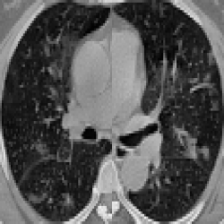

In [40]:
num = 102
imagem = cts_test[num]
mascara = infections_test[num]
cv2_imshow(imagem)

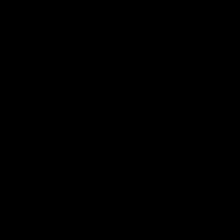

In [41]:
img = segment_instance(cts_test[100], model, CLASS_NAMES, confidence=conf)
cv2_imshow(img)

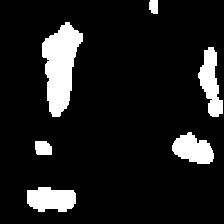

In [42]:
mask = Image.fromarray(np.uint8(mascara)).convert('RGB')
mask = np.asarray(mask)[:,:,::-1].copy()
mask = mask[:,:, 0]
cv2_imshow(mask)

In [36]:
metrics = calc_metrics(mask, img)
print('Teste')
print('TP - : '+str(metrics[0]))
print('TN - : '+str(metrics[1]))
print('FP - : '+str(metrics[2]))
print('FN - : '+str(metrics[3]))
print('J - : '+str(metrics[4]))
print('D - : '+str(metrics[5]))
print('P - : '+str(metrics[6]))
print('R - : '+str(metrics[7]))
print('E - : '+str(metrics[8]))
print('A - : '+str(metrics[9]))

Teste
TP - : 0
TN - : 26528
FP - : 0
FN - : 23648
J - : 0.0
D - : 0.0
P - : 0
R - : 0.0
E - : 1.0
A - : 0.5286989795918368
